In [1]:
from IPython.display import HTML
hide_me = ''
HTML('''<script>
code_show=true; 
function code_toggle() {
  if (code_show) {
    $('div.input').each(function(id) {
      if (id == 0 || $(this).html().indexOf('hide_me') > -1) {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input style="opacity:100" type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Identifying Fraud from Enron Email
by Mark Lin

# 1.Introduction  

Enron Corporation was one of the biggest American company in energy, commodities, and services, which filed bankruptcy in late 2001 due to a huge accounting fraud. Since then, Enron had become a well-known corporation fraud example, and lots of inside information went public. Including tons of email messages and financial data of their major employees.

The goal of this project is to analyze these available data, select some features that help us to distinguish the suspects of this fraud (we call them POI, person of interst in the dataset).

We will use machine learning algorithms to learn certain behaviors that showed in the dataset from those people who are POI, and see if there is a pattern that we can apply to recognize some suspects from outside the dataset.

# 2.Data Exploration and Preparation

## 2.1 Data Overview 

In [2]:
hide_me
import sys
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from __future__ import division 
from time import time
from sklearn.grid_search import GridSearchCV
sys.path.append("../tools/")

C:\Users\Limit50908\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Limit50908\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
hide_me
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
hide_me
df = pd.DataFrame(data_dict)
df = df.T
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


In [5]:
hide_me
print "Number of features: ", len(df.columns)
print "Number of observations: ", len(df.index)
columns = pd.DataFrame(df.columns)
columns.T

Number of features:  21
Number of observations:  146


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value


There are 21 columns in the dataset, which represent 21 features, and 146 observations, which means we have the 146 people's fiancial data.

In [6]:
hide_me
print "Number of Poi:", len([a for a in df['poi'] if a== True])
print "Number of non-Poi:", len([a for a in df['poi'] if a== False])

Number of Poi: 18
Number of non-Poi: 128


Among those 146 obeservations, 18 of them are poi, other 128 are not.

## 2.2 Data Cleaning

Notice that we have quite a few NaN values in the dataset, reffering to the pdf file "enron61702insiderpay", I found that total payment is the sum of "salary", "bonus", "long term incentives", "deffered income", "deferral payment", "loan advances", "other", "expenses" and "director fees". The missing value in those columns are actual 0 since the employee did not get those payments. Same here, "total stock value" is the sum of "Exercised Stock Options", "Restricted Stock", "Restricted Stock Deferred", NaNs are also 0 in these cases. 

In [7]:
for i in df["poi"].isnull():
    if i :
        print  i.index()

From the script above, we did not encounter any NaN in "poi" column, and for "email adress" column, I will leave NaN cause we really don't have their emails recorded. For "shared_receipts_with_poi", I'll assume the NaNs are simply 0, it might not be true in some cases, but overall I think it's pretty rational to make this assumption. For those four columns, which are related to "email address" like "to_message", "from_message", "from_poi_to_this_person" and "from_this_person_to_poi", the NaNs in these columns is actually 0 since their email address isn't available, and for those NaNs that have validated email address, I will again, assume the value is 0.

In [8]:
hide_me
df = df.replace("NaN", 0)
df["email_address"] = df["email_address"].replace(0, "NaN")
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,0,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,0,178980,0,0,NaN,257817,3486,0,0,0,...,0,0,False,0,0,0,0,0,182466,257817
BANNANTINE JAMES M,0,0,-5104,0,james.bannantine@enron.com,4046157,56301,29,39,0,...,0,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,0,NaN,6680544,11200,0,0,0,...,1586055,2660303,False,3942714,0,267102,0,0,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,0,frank.bay@enron.com,0,129142,0,0,0,...,0,69,False,145796,-82782,239671,0,0,827696,63014


## 2.3 Remove Outliers 

We have 21 features available, but I will take "email_address" out of the list. The reason is that "email_address" itself is not a number, couldn't have any outliers.Now, we've cleaned the dataset, it's time to find out if there's any outliers in the dataset. First, let's take a look at these features visually.

Populating the interactive namespace from numpy and matplotlib


C:\Users\Limit50908\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


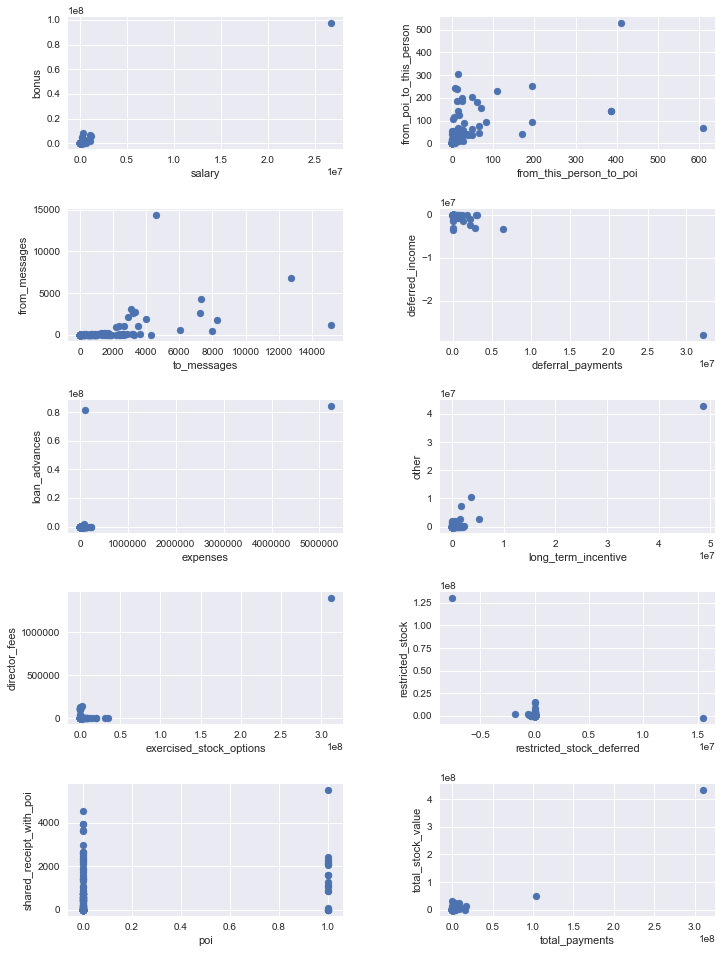

In [9]:
hide_me
%pylab inline
features = [{"x":"salary","y":"bonus"},{"x":"from_this_person_to_poi", "y":"from_poi_to_this_person"},
            {"x":"to_messages", "y":"from_messages"},{"x":"deferral_payments", "y":"deferred_income"},
            {"x":"expenses", "y":"loan_advances"},{"x":"long_term_incentive", "y":"other"},
            {"x":"exercised_stock_options", "y":"director_fees"},{"x":"restricted_stock_deferred", "y":"restricted_stock"},
            {"x":"poi", "y":"shared_receipt_with_poi"}, {"x":"total_payments", "y":"total_stock_value"}]


for i in range(0,10):
    plot = plt.subplot(5,2,i+1)
    feature = features[i]
    plt.scatter(x=df[feature["x"]], y=df[feature["y"]])
    plt.grid(True)
    plt.xlabel(feature["x"])
    plt.ylabel(feature["y"])
    plt.subplots_adjust(top=3.2, bottom=0.08, left=0.001, right=1.5, hspace=0.45, wspace=0.35)
   

From the plots, we can see that "from_this_person_to_poi" and "from_poi_to_this_person", "to_messages" and "from_messages", "poi" and "shared_receipt_with_poi" have no outliers. Other features have more or less outliers, so next step I am going to remove these points programmatically.

In [10]:
hide_me
df = df.drop(df.bonus.argmax())
#df = df.drop(df.total_payments.argmax())
#df = df.drop(df.total_stock_value.argmax())


1.The outlier of "salary" and "bonus" is TOTAL, which is not a person, so we should definitely remove this. After that, we still   see four points that lie far away from the majority, however, those are not outliers, the big number is reasonable, beacause     that's the salary and bonus of the chiefs in Enron.

2.Surprisingly to find, after remove the "TOTAL" out of the dataset, we do not see any weird outliers, though there is still      
  some outliers in terms of value.
  
3.Outliers can appear due to various reasons, for example, a typo from hunman being, in this case, since the numbers are not 
  impossible, so I will keep it in the dataset.
  
Let us see the plots without outliers.

Populating the interactive namespace from numpy and matplotlib


C:\Users\Limit50908\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


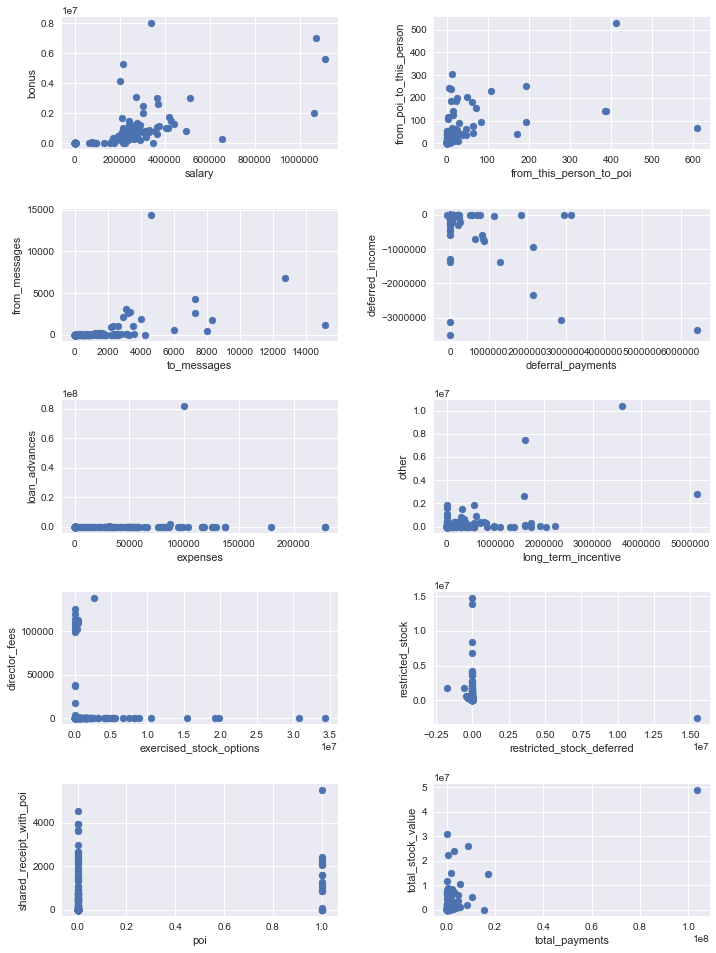

In [11]:
hide_me
%pylab inline
features = [{"x":"salary","y":"bonus"},{"x":"from_this_person_to_poi", "y":"from_poi_to_this_person"},
            {"x":"to_messages", "y":"from_messages"},{"x":"deferral_payments", "y":"deferred_income"},
            {"x":"expenses", "y":"loan_advances"},{"x":"long_term_incentive", "y":"other"},
            {"x":"exercised_stock_options", "y":"director_fees"},{"x":"restricted_stock_deferred", "y":"restricted_stock"},
            {"x":"poi", "y":"shared_receipt_with_poi"}, {"x":"total_payments", "y":"total_stock_value"}]


for i in range(0,10):
    plot = plt.subplot(5,2,i+1)
    feature = features[i]
    plt.scatter(x=df[feature["x"]], y=df[feature["y"]])
    plt.grid(True)
    plt.xlabel(feature["x"])
    plt.ylabel(feature["y"])
    plt.subplots_adjust(top=3.2, bottom=0.08, left=0.001, right=1.5, hspace=0.45, wspace=0.35)

# 3 Select and Create Features

## 3.1 Creating features and implementation

We have cleaned and outliers free dataset, it is time to select and create features that being used in machine learning.

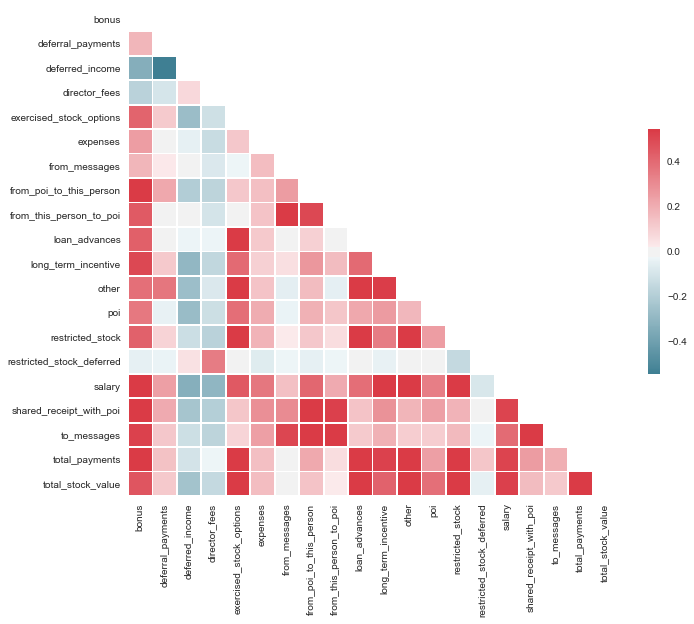

In [12]:
hide_me
sns.set(style="white")
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.8, cbar_kws={"shrink": .5}, ax=ax)

The purpose of the correlation heat map is help create new features. I will create some new features based on the high correlated variables, because we do not want to create random variables by using random variables, which will avoid overfitting. I will create three new features here, the first one is "wealth", I create "wealth" by adding up five high correlated variables, which are "salary"/"bonus"/"long_term_incentive"/"restricted_stock"/"other". The reason why I create this is because, people are easier to fraud if they have wealth and power in their position. The second and third one are "proportion_from_poi_mail"/ "proportion_to_poi_mail". People are more suspicious if they talked a lot with the poi, "proportion_from_poi_mail" is defined as a fraction of "from_poi_to_this_person" to "to_messages", while 'proportion_to_poi_mail' is defined as a proportion of "from_this_person_to_poi" to "from_messages".

In [13]:
hide_me
df['wealth'] = df["salary"] + df["bonus"] + df["long_term_incentive"] + df["restricted_stock"] + df["other"]
df['proportion_from_poi_mail'] = df["from_poi_to_this_person"]/df["to_messages"] 
df['proportion_to_poi_mail'] = df["from_this_person_to_poi"]/df["from_messages"]
df['wealth'].fillna(0, inplace=True)
df['proportion_from_poi_mail'].fillna(0, inplace=True)
df['proportion_to_poi_mail'].fillna(0, inplace=True)

In [14]:
hide_me
features_to_test = ['poi','bonus','salary','deferral_payments','deferred_income','director_fees',
                    'exercised_stock_options','expenses','total_payments','total_stock_value',
                    'from_messages','from_poi_to_this_person','from_this_person_to_poi',
                    'loan_advances','long_term_incentive','other','restricted_stock',
                    'restricted_stock_deferred','shared_receipt_with_poi','to_messages', 
                    'proportion_to_poi_mail', 'proportion_from_poi_mail', 'wealth']
dic = df.to_dict(orient="index")

In [15]:
hide_me
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from tester import test_classifier

combined_features = FeatureUnion([('scale', MinMaxScaler())])
estimators = [('features', combined_features),('classify', DecisionTreeClassifier())]
pclf = Pipeline(estimators)

test_classifier(pclf, dic, features_to_test)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1)))],
       transformer_weights=None)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.81787	Precision: 0.29553	Recall: 0.26450	F1: 0.27916	F2: 0.27017
	Total predictions: 15000	True positives:  529	False positives: 1261	False negatives: 1471	True negatives: 11739



In [16]:
hide_me
importances = pclf.steps[-1][1].feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(22):
    print("%d. %s (%0.2f)" % (f + 1, features_to_test[1:][indices[f]], importances[indices[f]]))

1. exercised_stock_options (0.33)
2. bonus (0.18)
3. proportion_to_poi_mail (0.13)
4. shared_receipt_with_poi (0.13)
5. other (0.07)
6. total_payments (0.06)
7. expenses (0.05)
8. wealth (0.04)
9. from_poi_to_this_person (0.02)
10. long_term_incentive (0.00)
11. loan_advances (0.00)
12. from_this_person_to_poi (0.00)
13. proportion_from_poi_mail (0.00)
14. from_messages (0.00)
15. total_stock_value (0.00)
16. restricted_stock (0.00)
17. restricted_stock_deferred (0.00)
18. to_messages (0.00)
19. director_fees (0.00)
20. deferred_income (0.00)
21. deferral_payments (0.00)
22. salary (0.00)


Based on the "importances" and correlation heatmap, I will keep the only 9 features that contibute to this algorithm and see how it performs. 

In [17]:
hide_me
features_to_test_2 = ['poi', 'bonus', 'total_stock_value', 'shared_receipt_with_poi',
                  'long_term_incentive', 'deferred_income',
                 'exercised_stock_options', 'total_payments', 'proportion_to_poi_mail']

In [18]:
hide_me
t0 = time()
test_classifier(pclf, dic, features_to_test_2)
print "Time used: ",  round(time()-t0, 2)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1)))],
       transformer_weights=None)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.84587	Precision: 0.41667	Recall: 0.39000	F1: 0.40289	F2: 0.39506
	Total predictions: 15000	True positives:  780	False positives: 1092	False negatives: 1220	True negatives: 11908

Time used:  3.76


We got a better result than keeping these factors in our model, therefore, I will select, ['poi','bonus', 'total_payments', 'shared_receipt_with_poi', 'salary', 'wealth','total_stock_value','from_poi_to_this_person', 'deferred_income', "to_messages", 
'from_this_person_to_poi','other','restricted_stock', "proportion_to_poi_mail"], these 14 features.

# 4.Pick and Tune an Algorithm

We've selected those effective features by optimizing the accuracy of decision tree algorithm. However, we would never know how good can the accuracy be if we do not try out other algorithms and tuning the parametres. In this section, I am gonna pick a best algorithm that gives best shot. 

## 4.1 Algorithm Performance

## Naive Bayes

In [19]:
hide_me
from sklearn.naive_bayes import GaussianNB

t0 = time()
estimators_2 = [('features', combined_features),('classify', GaussianNB())]
pclf_2 = Pipeline(estimators_2)
test_classifier(pclf_2, dic, features_to_test_2)
print "Time used: ",  round(time()-t0, 2)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1)))],
       transformer_weights=None)), ('classify', GaussianNB(priors=None))])
	Accuracy: 0.84873	Precision: 0.41087	Recall: 0.31000	F1: 0.35338	F2: 0.32601
	Total predictions: 15000	True positives:  620	False positives:  889	False negatives: 1380	True negatives: 12111

Time used:  4.0


## Random Forest

In [20]:
hide_me
from sklearn.ensemble import RandomForestClassifier

t0 = time()
estimators_3 = [('features', combined_features),('classify', RandomForestClassifier())]
pclf_3 = Pipeline(estimators_3)
test_classifier(pclf_3, dic, features_to_test_2)
print "Time used: ",  round(time()-t0, 2)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1)))],
       transformer_weights=None)), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', ...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
	Accuracy: 0.86880	Precision: 0.52116	Recall: 0.19700	F1: 0.28592	F2: 0.22499
	Total predictions: 15000	True positives:  394	False positives:  362	False negatives: 1606	True negatives: 12638

Time used:  47.52


## K Nearest Neighbor

In [21]:
hide_me
from sklearn.neighbors import KNeighborsClassifier

t0 = time()
estimators_4 = [('features', combined_features),('classify', KNeighborsClassifier())]
pclf_4 = Pipeline(estimators_4)
test_classifier(pclf_4, dic, features_to_test_2)
print "Time used: ",  round(time()-t0, 2)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1)))],
       transformer_weights=None)), ('classify', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
	Accuracy: 0.85220	Precision: 0.21671	Recall: 0.04150	F1: 0.06966	F2: 0.04950
	Total predictions: 15000	True positives:   83	False positives:  300	False negatives: 1917	True negatives: 12700

Time used:  5.02


In [22]:
hide_me
index = ["Accuracy", "Precision", "Recall", "Time"]
Performance = pd.DataFrame(data={"Decision Tree": [0.81521, 0.30446, 0.22850, 3.51],
                                 "Naive Bayes": [0.82450, 0.38216, 0.37050, 3.53], 
                                 "K Nearest Neighbour": [0.86686, 0.68994, 0.12350, 4.23],
                                 "Random Forest": [0.85179, 0.40554, 0.08050, 43.4] }, index=index)
Performance

,Decision Tree,K Nearest Neighbour,Naive Bayes,Random Forest
Accuracy,0.81521,0.86686,0.82450,0.85179
Precision,0.30446,0.68994,0.38216,0.40554
Recall,0.22850,0.12350,0.37050,0.08050
Time,3.51000,4.23000,3.53000,43.40000


## 4.2 Tuning algorithms

We have already got the performance of all our algorithms, however, it is not yet to judge which algorithm is the best one. To maximize the performance of an algorithm, we need to tune the key pamareters, which means to adjust the value of the parameters in the classifier. Switching gears to reach the fastest speed.

### Tuning Decision Trees

In [23]:
hide_me
parameters = {'criterion':('gini', 'entropy'), 
             'splitter':('best','random')}
pcl_1 = GridSearchCV(DecisionTreeClassifier(), param_grid = parameters,scoring = 'recall')
pcl_1.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best'),
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_split': 1e-07,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__presort': False,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'fit_params': {},
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'criterion': ('gini', 'entropy'),
  'splitter': ('best', 'random')},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'scoring': 'recall',
 'verbose':

The best parameters we got from GridsearchCV is exact the same as default.

### Tuning K Nearest Neighbours

In [24]:
hide_me
parameters = {'n_neighbors':[1,10], 'weight':['uniform', 'distance'], 'algorithm':('ball_tree','kd_tree','brute','auto'),
             'leaf_size': [0, 50], 'p': [1, 10], 'n_jobs': [0, 10]}
pcl_3 = GridSearchCV(KNeighborsClassifier(), param_grid = parameters,scoring = 'recall')
pcl_3.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
            weights='uniform'),
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': 1,
 'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'fit_params': {},
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'algorithm': ('ball_tree', 'kd_tree', 'brute', 'auto'),
  'leaf_size': [0, 50],
  'n_jobs': [0, 10],
  'n_neighbors': [1, 10],
  'p': [1, 10],
  'weight': ['uniform', 'distance']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'scoring': 'recall',
 'verbose': 0}

We found that the pamareters in the original test was already the best tuned.

### Tuning Random Forest

In [25]:
hide_me
parameters = {'criterion':('gini', 'entropy'), "min_samples_split": [0, 10], "verbose": [0, 10],
             'n_estimators':[0, 30], "class_weight": ("balanced", None)}
pcl_4 = GridSearchCV(RandomForestClassifier(), param_grid = parameters,scoring = 'recall')
pcl_4.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=False),
 'estimator__bootstrap': True,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_split': 1e-07,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 10,
 'estimator__n_jobs': 1,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'fit_params': {},


Again, the default test of random forest is the best tuned.

### Final algorithm

Based on the performance of all the algorithms, Naive Bayes is the best one. Our final algorithm is Naive Bayes! 

# 5.Validate and Evaluate

## 5.1 Validation

Validation is the process of testing the performance of an algorithm using train/test spliting samples. Learning and testing a estimator using same data would cause overfitting, because a model would repeat the labels that were used to train, therefore it would get a high accuracy but is not validated or overestimate. To avoid overfitting and giving the true performance, I use StratifiedKFold cross validation to improve. We split the data set evenly into k parts(k is changable), each time, one of the k subsets is randomly choose as a test set and the other data been a training set, then we calculate the overall average score. The advantage of StratifiedKFold cross validation is that every single data point goes to a test set once, thus the a data point won't a test point and train point at the same time. Another advantage is that we do not have sufficient data, this method can help to reduce the inaccuracy due to lack of data. These two advantages are shared by both StratifiedKFold and normal kfold method, the reason we choose StratifiedKFold over kfold is because we are dealing with small imbalanced datasets in this case, it is possible that some folds contain almost none (or even none!) instances of the minority class. The idea behind stratification is to keep the percentage of the target class as close as possible to the one we have in the complete dataset. The sample data set spread more evenly, thus we are testing a sample that are highly similar to the original full data set.  

In [29]:
hide_me
from feature_format import featureFormat, targetFeatureSplit
data = featureFormat(dic, features_to_test_2, sort_keys = True)
labels, features = targetFeatureSplit(data)
def cross_validation():
    import sklearn.metrics
    from sklearn.cross_validation import train_test_split                          
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)
    #from sklearn.cross_validation import KFold
    from sklearn.model_selection import StratifiedKFold #New adding
    precisions = [] #New adding
    recalls = [] #New adding
    scores = []
    #skf=KFold(len(labels),3) 
    skf = StratifiedKFold(n_splits=3) #new adding
    for train_indices, test_indices in skf.split(features, labels):
        features_train= [features[ii] for ii in train_indices]
        features_test= [features[ii] for ii in test_indices]
        labels_train=[labels[ii] for ii in train_indices]
        labels_test=[labels[ii] for ii in test_indices]
        from sklearn.naive_bayes import GaussianNB
        clf = GaussianNB()
        clf.fit(features_train,labels_train)
        pred= clf.predict(features_test)
        scores.append(sklearn.metrics.accuracy_score(labels_test, pred))
        precisions.append(sklearn.metrics.precision_score(labels_test, pred))
        recalls.append(sklearn.metrics.recall_score(labels_test, pred))
    
    print "accuracy:", np.mean(scores)
    print "precision:", np.mean(precisions)
    print "recall:", np.mean(recalls)

In [28]:
cross_validation()

accuracy: 0.833333333333
precision: 0.331746031746
recall: 0.333333333333


## 5.2 Evaluation

Accuracy is good metric in evaluating the performance of a model. However, it has a few tangible shortcomings that we can not omit. The first one is that it is not very useful in skewed classes, which is the case in this data set, since most of employees were not involved in this fraud. In this case, lots of labels are not poi, therefore, predictions will not be accurate. The second is that we may be more interested in only predicting the poi correctly than overall prediction, which include predicting non poi correctly, say, the poi would be put in jail for a long period, so we don't want the innocent people to take this risk. The third one is that sometimes, especially in identifying fraud cases, we typically want a broad circle to include as many potential suspects as possible so that we can do further investigation to free those innocent people.

Based on our concerns above, a single accuracy metric is not enough. Therefore we introduce two more metrics to help make a good decision, precision and recall. Like its literal meaning, precision means that we aim to find the suspect without harming the innocence, in this specific case,  it can be interpreted as the likelihood that a person identified as a POI is actually a true POI. Recall means we want to get as more suspects as possible, in this case, it can be interpreted as th fraction of poi that is detected among all the poi. In fraud cases, we would like a higher recall even if sacrifice precision. The precision and recall rate in our algorithms are not very high, however, it is for sure better than wild guesses.


# Referrences

seaborn.heatmap http://seaborn.pydata.org/generated/seaborn.heatmap.html

 random forest sklearn documentation http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

KNN sklearn documentation  http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

decision tree sklearn documentation http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

naive bayes sklearn documentation http://scikit-learn.org/stable/modules/naive_bayes.html

Model Validation, Machine Learning https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-9863-7_233

cross validation https://www.cs.cmu.edu/~schneide/tut5/node42.html

StratifiedKFold http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html